In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import pinv

# Set font tiếng Việt 
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False



[1] Đang mô phỏng mô hình Hodgkin-Huxley...
✓ Đã lưu kết quả vào file: hodgkin_huxley.png


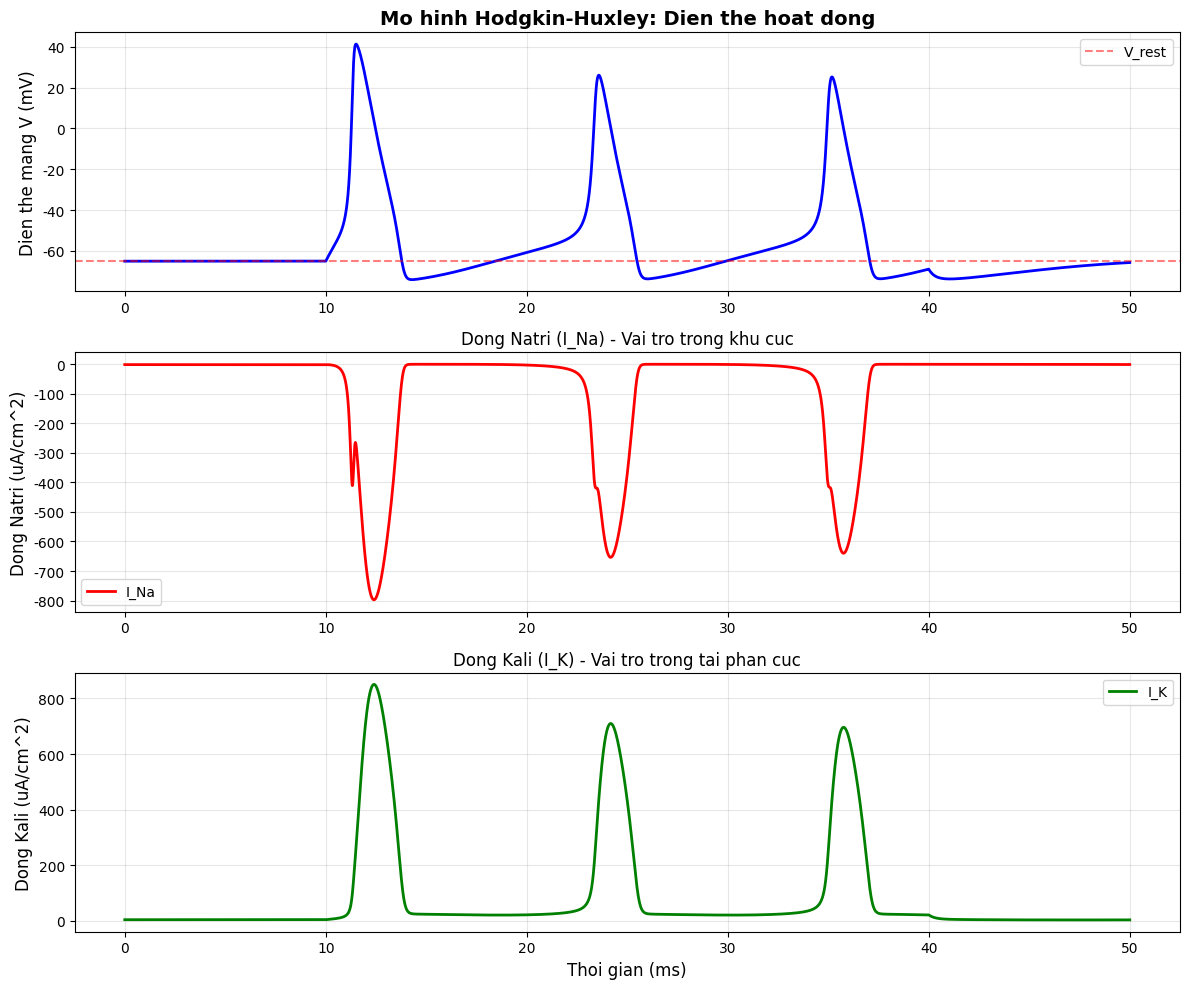

In [35]:
# ============================================================================
# PHẦN 1: MÔ HÌNH HODGKIN-HUXLEY
# ============================================================================
print("\n[1] Đang mô phỏng mô hình Hodgkin-Huxley...")

class HodgkinHuxley:
    """Mô hình Hodgkin-Huxley cho điện thế hoạt động của neuron"""
    
    def __init__(self):
        # Các tham số của mô hình (theo bài báo gốc)
        self.C_m = 1.0      # Điện dung màng (μF/cm²)
        self.g_Na = 120.0   # Độ dẫn tối đa Na (mS/cm²)
        self.g_K = 36.0     # Độ dẫn tối đa K (mS/cm²)
        self.g_L = 0.3      # Độ dẫn rò rỉ (mS/cm²)
        self.E_Na = 50.0    # Điện thế đảo ngược Na (mV)
        self.E_K = -77.0    # Điện thế đảo ngược K (mV)
        self.E_L = -54.4    # Điện thế đảo ngược rò rỉ (mV)
        
    def alpha_m(self, V):
        """Hàm tốc độ alpha cho cổng kích hoạt m của Na"""
        return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))
    
    def beta_m(self, V):
        """Hàm tốc độ beta cho cổng kích hoạt m của Na"""
        return 4.0 * np.exp(-(V + 65.0) / 18.0)
    
    def alpha_h(self, V):
        """Hàm tốc độ alpha cho cổng bất hoạt h của Na"""
        return 0.07 * np.exp(-(V + 65.0) / 20.0)
    
    def beta_h(self, V):
        """Hàm tốc độ beta cho cổng bất hoạt h của Na"""
        return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))
    
    def alpha_n(self, V):
        """Hàm tốc độ alpha cho cổng kích hoạt n của K"""
        return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))
    
    def beta_n(self, V):
        """Hàm tốc độ beta cho cổng kích hoạt n của K"""
        return 0.125 * np.exp(-(V + 65.0) / 80.0)
    
    def I_Na(self, V, m, h):
        """Dòng Natri"""
        return self.g_Na * m**3 * h * (V - self.E_Na)
    
    def I_K(self, V, n):
        """Dòng Kali"""
        return self.g_K * n**4 * (V - self.E_K)
    
    def I_L(self, V):
        """Dòng rò rỉ"""
        return self.g_L * (V - self.E_L)
    
    def derivatives(self, y, t, I_ext):
        """Tính đạo hàm cho hệ phương trình vi phân"""
        V, m, h, n = y
        
        # Tính các dòng ion
        dV = (I_ext(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dm = self.alpha_m(V) * (1.0 - m) - self.beta_m(V) * m
        dh = self.alpha_h(V) * (1.0 - h) - self.beta_h(V) * h
        dn = self.alpha_n(V) * (1.0 - n) - self.beta_n(V) * n
        
        return [dV, dm, dh, dn]

# Thiết lập thông số mô phỏng HH
hh = HodgkinHuxley()
V0 = -65.0  # Điện thế màng ban đầu (mV)

# Tính trạng thái ban đầu ở trạng thái nghỉ
m0 = hh.alpha_m(V0) / (hh.alpha_m(V0) + hh.beta_m(V0))
h0 = hh.alpha_h(V0) / (hh.alpha_h(V0) + hh.beta_h(V0))
n0 = hh.alpha_n(V0) / (hh.alpha_n(V0) + hh.beta_n(V0))
y0 = [V0, m0, h0, n0]

# Dòng điện kích thích: step input
def I_ext_hh(t):
    if 10 <= t <= 40:
        return 20.0  # μA/cm²
    return 0.0

# Thời gian mô phỏng
t_hh = np.linspace(0, 50, 5000)

# Giải hệ phương trình vi phân
solution_hh = odeint(hh.derivatives, y0, t_hh, args=(I_ext_hh,))
V_hh = solution_hh[:, 0]
m_hh = solution_hh[:, 1]
h_hh = solution_hh[:, 2]
n_hh = solution_hh[:, 3]

# Tính các dòng ion
I_Na_hh = np.array([hh.I_Na(V_hh[i], m_hh[i], h_hh[i]) for i in range(len(t_hh))])
I_K_hh = np.array([hh.I_K(V_hh[i], n_hh[i]) for i in range(len(t_hh))])

# Vẽ đồ thị Hodgkin-Huxley
fig1, axes1 = plt.subplots(3, 1, figsize=(12, 10))

axes1[0].plot(t_hh, V_hh, 'b', linewidth=2)
axes1[0].set_ylabel('Dien the mang V (mV)', fontsize=12)
axes1[0].set_title('Mo hinh Hodgkin-Huxley: Dien the hoat dong', fontsize=14, fontweight='bold')
axes1[0].grid(True, alpha=0.3)
axes1[0].axhline(y=V0, color='r', linestyle='--', alpha=0.5, label='V_rest')
axes1[0].legend()

axes1[1].plot(t_hh, I_Na_hh, 'r', linewidth=2, label='I_Na')
axes1[1].set_ylabel('Dong Natri (uA/cm^2)', fontsize=12)
axes1[1].set_title('Dong Natri (I_Na) - Vai tro trong khu cuc', fontsize=12)
axes1[1].grid(True, alpha=0.3)
axes1[1].legend()

axes1[2].plot(t_hh, I_K_hh, 'g', linewidth=2, label='I_K')
axes1[2].set_xlabel('Thoi gian (ms)', fontsize=12)
axes1[2].set_ylabel('Dong Kali (uA/cm^2)', fontsize=12)
axes1[2].set_title('Dong Kali (I_K) - Vai tro trong tai phan cuc', fontsize=12)
axes1[2].grid(True, alpha=0.3)
axes1[2].legend()

plt.tight_layout()
plt.savefig('hodgkin_huxley.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu kết quả vào file: hodgkin_huxley.png")



[2] Đang mô phỏng mô hình Leaky Integrate-and-Fire...
✓ Đã lưu kết quả vào file: leaky_integrate_fire.png


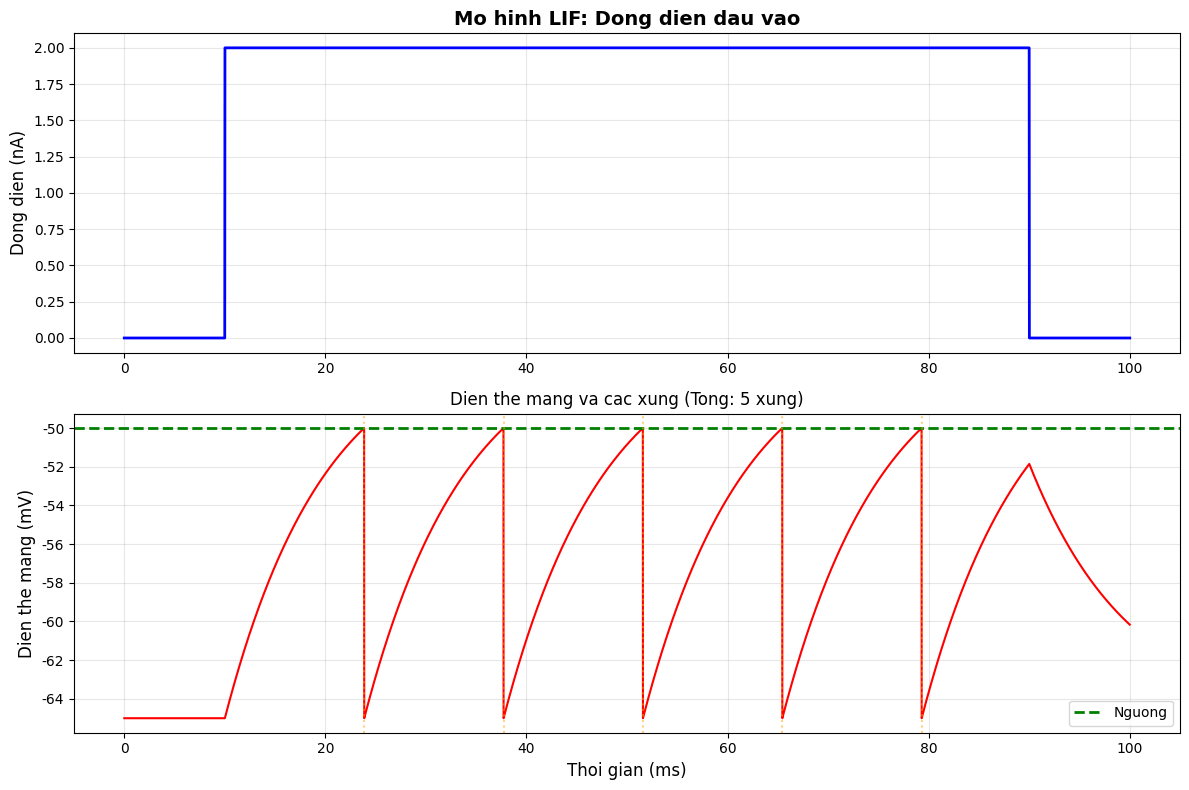

In [36]:
# ============================================================================
# PHẦN 2: MÔ HÌNH LEAKY INTEGRATE-AND-FIRE (LIF)
# ============================================================================
print("\n[2] Đang mô phỏng mô hình Leaky Integrate-and-Fire...")

class LeakyIntegrateFire:
    """Mô hình LIF đơn giản"""
    
    def __init__(self):
        self.tau = 10.0         # Hằng số thời gian màng (ms)
        self.V_rest = -65.0     # Điện thế nghỉ (mV)
        self.V_threshold = -50.0  # Ngưỡng phát xung (mV)
        self.V_reset = -65.0    # Điện thế reset (mV)
        self.R = 10.0           # Điện trở màng (MΩ)
        
    def simulate(self, t, I_ext):
        """Mô phỏng mô hình LIF"""
        dt = t[1] - t[0]
        V = np.zeros(len(t))
        V[0] = self.V_rest
        spikes = []
        
        for i in range(1, len(t)):
            # Phương trình LIF: tau * dV/dt = -(V - V_rest) + R*I(t)
            dV = (-(V[i-1] - self.V_rest) + self.R * I_ext[i-1]) / self.tau
            V[i] = V[i-1] + dV * dt
            
            # Kiểm tra ngưỡng
            if V[i] >= self.V_threshold:
                V[i] = self.V_reset
                spikes.append(t[i])
                
        return V, spikes

# Thiết lập mô phỏng LIF
lif = LeakyIntegrateFire()
t_lif = np.linspace(0, 100, 10000)
dt_lif = t_lif[1] - t_lif[0]

# Tạo dòng điện đầu vào dạng sóng vuông
I_ext_lif = np.zeros(len(t_lif))
I_ext_lif[(t_lif >= 10) & (t_lif <= 90)] = 2.0  # 2 nA

# Chạy mô phỏng
V_lif, spikes_lif = lif.simulate(t_lif, I_ext_lif)

# Vẽ đồ thị LIF
fig2, axes2 = plt.subplots(2, 1, figsize=(12, 8))

axes2[0].plot(t_lif, I_ext_lif, 'b', linewidth=2)
axes2[0].set_ylabel('Dong dien (nA)', fontsize=12)
axes2[0].set_title('Mo hinh LIF: Dong dien dau vao', fontsize=14, fontweight='bold')
axes2[0].grid(True, alpha=0.3)

axes2[1].plot(t_lif, V_lif, 'r', linewidth=1.5)
axes2[1].axhline(y=lif.V_threshold, color='g', linestyle='--', linewidth=2, label='Nguong')
for spike_time in spikes_lif:
    axes2[1].axvline(x=spike_time, color='orange', linestyle=':', alpha=0.5)
axes2[1].set_xlabel('Thoi gian (ms)', fontsize=12)
axes2[1].set_ylabel('Dien the mang (mV)', fontsize=12)
axes2[1].set_title(f'Dien the mang va cac xung (Tong: {len(spikes_lif)} xung)', fontsize=12)
axes2[1].grid(True, alpha=0.3)
axes2[1].legend()

plt.tight_layout()
plt.savefig('leaky_integrate_fire.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu kết quả vào file: leaky_integrate_fire.png")



[3] Đang mô phỏng Echo State Network cho chuỗi Mackey-Glass...
   Đang tạo chuỗi Mackey-Glass...
   Đang huấn luyện Echo State Network...
   Đang dự đoán tương lai gần (t+10)...
   Đang dự đoán tương lai xa (t+100)...
   RMSE t+10: 3.593087
   RMSE t+100: 5.719920
✓ Đã lưu kết quả vào file: echo_state_network.png


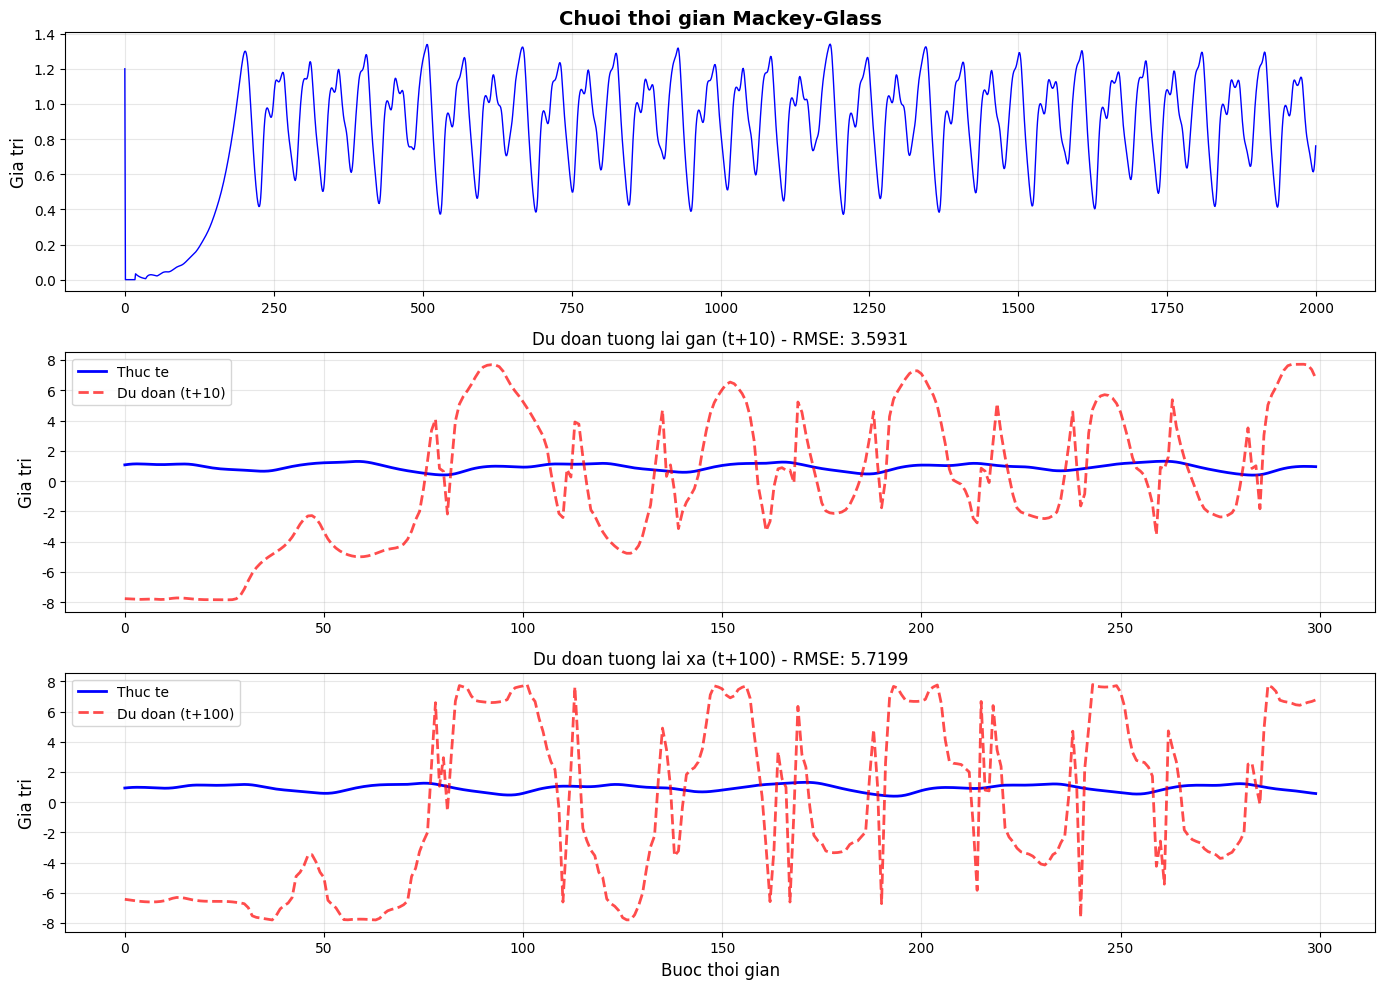

In [37]:
# ============================================================================
# PHẦN 3: RESERVOIR NEURAL NETWORK - MACKEY-GLASS TIME SERIES
# ============================================================================
print("\n[3] Đang mô phỏng Echo State Network cho chuỗi Mackey-Glass...")

def mackey_glass(length=5000, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    """Tạo chuỗi thời gian Mackey-Glass"""
    x = np.zeros(length)
    x[0] = x0
    
    for t in range(tau, length-1):
        x[t+1] = x[t] + (beta * x[t-tau] / (1 + x[t-tau]**n) - gamma * x[t])
    
    return x

class EchoStateNetwork:
    """Echo State Network cho dự đoán chuỗi thời gian"""
    
    def __init__(self, n_inputs, n_reservoir, n_outputs, spectral_radius=0.95, sparsity=0.1):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        
        # Ma trận trọng số input (random)
        self.W_in = np.random.uniform(-0.5, 0.5, (n_reservoir, n_inputs))
        
        # Ma trận reservoir (sparse, random)
        self.W_res = np.random.uniform(-0.5, 0.5, (n_reservoir, n_reservoir))
        # Tạo sparsity
        mask = np.random.rand(n_reservoir, n_reservoir) > sparsity
        self.W_res *= mask
        
        # Điều chỉnh spectral radius
        eigenvalues = np.linalg.eigvals(self.W_res)
        current_spectral_radius = np.max(np.abs(eigenvalues))
        self.W_res *= spectral_radius / current_spectral_radius
        
        # Ma trận output (sẽ được học)
        self.W_out = None
        
    def update_state(self, state, input_val):
        """Cập nhật trạng thái reservoir"""
        pre_activation = np.dot(self.W_in, input_val) + np.dot(self.W_res, state)
        return np.tanh(pre_activation)
    
    def train(self, inputs, targets, washout=100, ridge_param=1e-6):
        """Huấn luyện ESN bằng Ridge Regression"""
        n_samples = len(inputs) - washout
        states = np.zeros((n_samples, self.n_reservoir))
        state = np.zeros(self.n_reservoir)
        
        # Thu thập trạng thái reservoir
        for t in range(washout):
            state = self.update_state(state, inputs[t])
        
        for t in range(n_samples):
            state = self.update_state(state, inputs[t + washout])
            states[t] = state
        
        # Ridge Regression
        targets_train = targets[washout:washout + n_samples]
        # W_out = Y @ X^T @ (X @ X^T + λI)^-1
        X = states.T
        Y = targets_train.reshape(-1, 1).T
        self.W_out = Y @ X.T @ np.linalg.inv(X @ X.T + ridge_param * np.eye(self.n_reservoir))
        
        return states
    
    def predict(self, initial_state, initial_input, n_steps):
        """Dự đoán tương lai"""
        predictions = []
        state = initial_state.copy()
        current_input = initial_input.copy()
        
        for _ in range(n_steps):
            state = self.update_state(state, current_input)
            output = np.dot(self.W_out, state)[0]
            predictions.append(output)
            current_input = np.array([output])
        
        return np.array(predictions)

# Tạo chuỗi Mackey-Glass
print("   Đang tạo chuỗi Mackey-Glass...")
mg_series = mackey_glass(length=5000)

# Chuẩn bị dữ liệu
train_len = 3000
test_len = 1000

data = mg_series[:train_len + test_len]
inputs = data[:-1].reshape(-1, 1)
targets = data[1:]

# Tạo và huấn luyện ESN
print("   Đang huấn luyện Echo State Network...")
esn = EchoStateNetwork(n_inputs=1, n_reservoir=400, n_outputs=1, 
                       spectral_radius=0.95, sparsity=0.1)

states = esn.train(inputs[:train_len], targets[:train_len], washout=100)

# Dự đoán short-term (t+10)
print("   Đang dự đoán tương lai gần (t+10)...")
predictions_short = []
washout = 100
n_states = len(states)

# Dự đoán từ cuối training set
for i in range(test_len - 10):
    if i < n_states:
        current_input = np.array([data[train_len + i]])
        pred = esn.predict(states[min(i, n_states-1)], current_input, n_steps=10)
        predictions_short.append(pred[-1])

predictions_short = np.array(predictions_short)
# Đảm bảo actual_short có cùng kích thước với predictions_short
actual_short = targets[train_len + 10:train_len + 10 + len(predictions_short)]

# Kiểm tra và cắt để cùng kích thước
min_len_short = min(len(predictions_short), len(actual_short))
predictions_short = predictions_short[:min_len_short]
actual_short = actual_short[:min_len_short]

# Dự đoán long-term (t+100)
print("   Đang dự đoán tương lai xa (t+100)...")
predictions_long = []
test_len_long = min(300, test_len - 100, n_states)

for i in range(test_len_long):
    if i < n_states:
        current_input = np.array([data[train_len + i]])
        pred = esn.predict(states[min(i, n_states-1)], current_input, n_steps=100)
        predictions_long.append(pred[-1])

predictions_long = np.array(predictions_long)
# Đảm bảo actual_long có cùng kích thước với predictions_long
actual_long = targets[train_len + 100:train_len + 100 + len(predictions_long)]

# Kiểm tra và cắt để cùng kích thước
min_len_long = min(len(predictions_long), len(actual_long))
predictions_long = predictions_long[:min_len_long]
actual_long = actual_long[:min_len_long]

# Tính RMSE
if len(predictions_short) > 0 and len(actual_short) > 0:
    rmse_short = np.sqrt(np.mean((predictions_short - actual_short)**2))
else:
    rmse_short = float('nan')

if len(predictions_long) > 0 and len(actual_long) > 0:
    rmse_long = np.sqrt(np.mean((predictions_long - actual_long)**2))
else:
    rmse_long = float('nan')

print(f"   RMSE t+10: {rmse_short:.6f}")
print(f"   RMSE t+100: {rmse_long:.6f}")

# Vẽ đồ thị ESN
fig3, axes3 = plt.subplots(3, 1, figsize=(14, 10))

# Chuỗi Mackey-Glass
axes3[0].plot(mg_series[:2000], 'b', linewidth=1)
axes3[0].set_ylabel('Gia tri', fontsize=12)
axes3[0].set_title('Chuoi thoi gian Mackey-Glass', fontsize=14, fontweight='bold')
axes3[0].grid(True, alpha=0.3)

# Dự đoán t+10
axes3[1].plot(actual_short[:300], 'b-', label='Thuc te', linewidth=2)
axes3[1].plot(predictions_short[:300], 'r--', label='Du doan (t+10)', linewidth=2, alpha=0.7)
axes3[1].set_ylabel('Gia tri', fontsize=12)
axes3[1].set_title(f'Du doan tuong lai gan (t+10) - RMSE: {rmse_short:.4f}', fontsize=12)
axes3[1].grid(True, alpha=0.3)
axes3[1].legend()

# Dự đoán t+100
axes3[2].plot(actual_long[:300], 'b-', label='Thuc te', linewidth=2)
axes3[2].plot(predictions_long[:300], 'r--', label='Du doan (t+100)', linewidth=2, alpha=0.7)
axes3[2].set_xlabel('Buoc thoi gian', fontsize=12)
axes3[2].set_ylabel('Gia tri', fontsize=12)
axes3[2].set_title(f'Du doan tuong lai xa (t+100) - RMSE: {rmse_long:.4f}', fontsize=12)
axes3[2].grid(True, alpha=0.3)
axes3[2].legend()

plt.tight_layout()
plt.savefig('echo_state_network.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu kết quả vào file: echo_state_network.png")


In [38]:
# ============================================================================
# KẾT QUẢ TỔNG HỢP
# ============================================================================
print("\n" + "="*60)
print("KẾT QUẢ MÔ PHỎNG")
print("="*60)
print(f"\n1. HODGKIN-HUXLEY MODEL:")
print(f"   - Điện thế màng đạt cực đại: {np.max(V_hh):.2f} mV")
print(f"   - Dòng Na tối đa: {np.max(np.abs(I_Na_hh)):.2f} μA/cm²")
print(f"   - Dòng K tối đa: {np.max(np.abs(I_K_hh)):.2f} μA/cm²")

print(f"\n2. LEAKY INTEGRATE-AND-FIRE MODEL:")
print(f"   - Số xung phát sinh: {len(spikes_lif)} xung")
print(f"   - Tần số phát xung trung bình: {len(spikes_lif)/(t_lif[-1]-t_lif[0])*1000:.2f} Hz")

print(f"\n3. ECHO STATE NETWORK:")
print(f"   - RMSE dự đoán t+10: {rmse_short:.6f}")
print(f"   - RMSE dự đoán t+100: {rmse_long:.6f}")
print(f"   - Số neuron trong reservoir: {esn.n_reservoir}")

print("\n" + "="*60)
print("ĐÃ HOÀN THÀNH TẤT CẢ CÁC MÔ PHỎNG!")
print("Các file đồ thị đã được lưu:")
print("  - hodgkin_huxley.png")
print("  - leaky_integrate_fire.png")
print("  - echo_state_network.png")
print("="*60)

plt.show()


KẾT QUẢ MÔ PHỎNG

1. HODGKIN-HUXLEY MODEL:
   - Điện thế màng đạt cực đại: 41.30 mV
   - Dòng Na tối đa: 797.47 μA/cm²
   - Dòng K tối đa: 850.30 μA/cm²

2. LEAKY INTEGRATE-AND-FIRE MODEL:
   - Số xung phát sinh: 5 xung
   - Tần số phát xung trung bình: 50.00 Hz

3. ECHO STATE NETWORK:
   - RMSE dự đoán t+10: 3.593087
   - RMSE dự đoán t+100: 5.719920
   - Số neuron trong reservoir: 400

ĐÃ HOÀN THÀNH TẤT CẢ CÁC MÔ PHỎNG!
Các file đồ thị đã được lưu:
  - hodgkin_huxley.png
  - leaky_integrate_fire.png
  - echo_state_network.png
